# Doublet identification in snRNA (adult) dataset using _scrublet_ 

In [1]:
import matplotlib.pyplot as plt

from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix

from utils import *

In [2]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

Running Scanpy 1.8.1, on 2021-09-23 12:22.


## Create AnnData objects

In [3]:
metadata = pd.read_csv('/nfs/team205/heart/metadata/metadata_snRNA.csv', sep = ',', index_col = 0)

In [4]:
len(metadata.index)

94

In [5]:
adatas = []
for i in range(len(metadata.index)):
    
    sample_id = metadata.index[i]
    path = metadata.loc[metadata.index == sample_id, 'CellBender_out'].to_list()[0]
    filename = sample_id + '_cellbender_out_filtered.h5'

    adatas.append(anndata_from_h5(path + '/' +  filename, analyzed_barcodes_only=False))

In [6]:
n_nuclei = [adatas[i].n_obs for i in range(len(adatas))]
np.quantile(n_nuclei, q=[0.0, 0.25, 0.5, 0.75, 1.0])

array([  211.  ,  3389.5 ,  4700.5 ,  5539.25, 13327.  ])

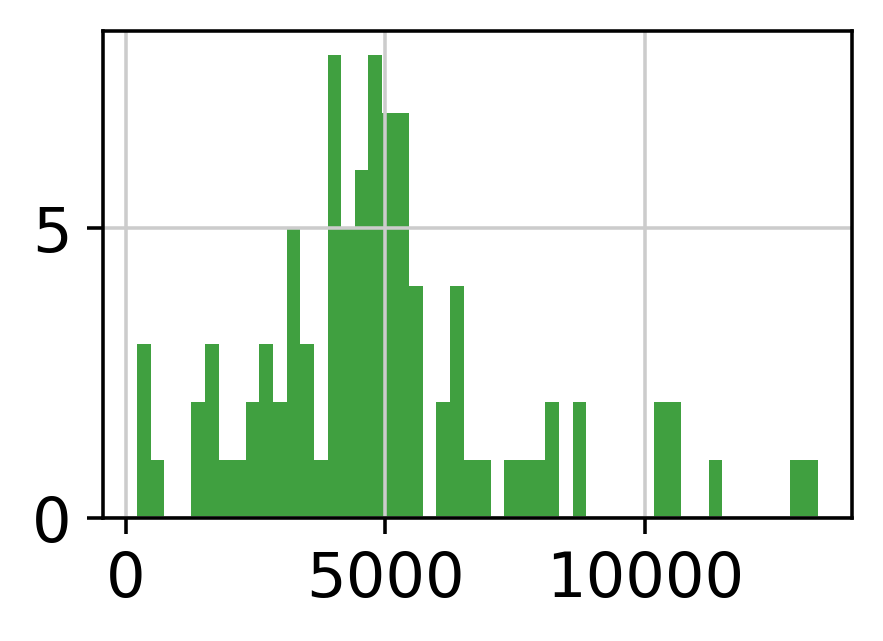

In [7]:
plt.rcParams['figure.figsize'] = [3, 2]
n, bins, patches = plt.hist(n_nuclei, 50, density=False, facecolor='g', alpha=0.75)

In [8]:
for i in range(len(adatas)):
    adatas[i].var_names_make_unique()
    adatas[i].obs['sample_id'] = metadata.index[i]
    adatas[i].obs.index = metadata.index[i] + '_' + adatas[i].obs.index 
    for col in metadata.columns:
        adatas[i].obs[col] = metadata[col][i]

adata = adatas[0].concatenate(adatas[1:], batch_categories = metadata.index)
adata.shape

(464734, 33538)

In [9]:
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['n_counts'].describe()

count    464734.000000
mean       2623.552734
std        3431.105469
min           0.000000
25%         733.000000
50%        1481.000000
75%        3407.000000
max      286023.000000
Name: n_counts, dtype: float64

## Remove cells with less than 200 genes, remove genes detected in less than 3 cells

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 20944 cells that have less than 200 genes expressed


/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 3619 genes that are detected in less than 3 cells


In [11]:
adata.shape

(443790, 29919)

## Compute QC stats

In [12]:
mito_cells = adata.var_names.str.startswith('MT-')
ribo_cells = adata.var_names.str.startswith('RPS','RPL')
adata.obs['percent_mito'] = np.sum(adata[:, mito_cells].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1)

# sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'], jitter = 0.2, multi_panel = True)
# for qc_metric in ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo']:
#     sc.pl.violin(adata, qc_metric, jitter = 0.2)

... storing 'sample_id' as categorical
... storing 'Foetal_or_Adult' as categorical
... storing 'Provider' as categorical
... storing 'Modality' as categorical
... storing 'Mapping_ver' as categorical
... storing 'Reference_genome' as categorical
... storing 'CellBender_out' as categorical
... storing 'feature_type-HCAHeart7656539' as categorical
... storing 'feature_type-HCAHeart7664652' as categorical
... storing 'feature_type-HCAHeart7664653' as categorical
... storing 'feature_type-HCAHeart7664654' as categorical
... storing 'feature_type-HCAHeart7698015' as categorical
... storing 'feature_type-HCAHeart7698016' as categorical
... storing 'feature_type-HCAHeart7698017' as categorical
... storing 'feature_type-HCAHeart7702873' as categorical
... storing 'feature_type-HCAHeart7702874' as categorical
... storing 'feature_type-HCAHeart7702875' as categorical
... storing 'feature_type-HCAHeart7702876' as categorical
... storing 'feature_type-HCAHeart7702877' as categorical
... storing '

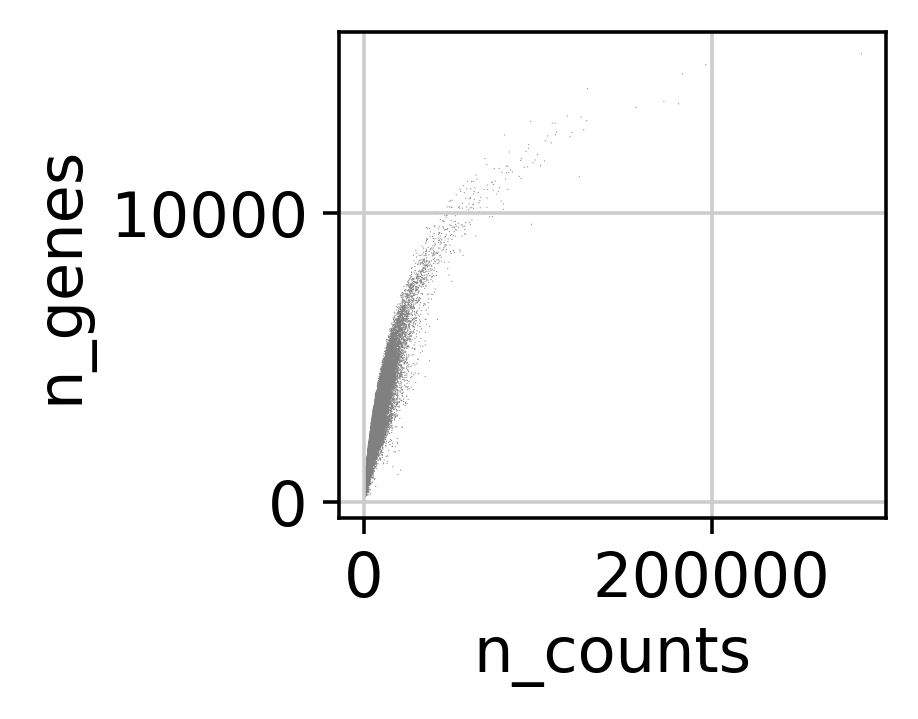

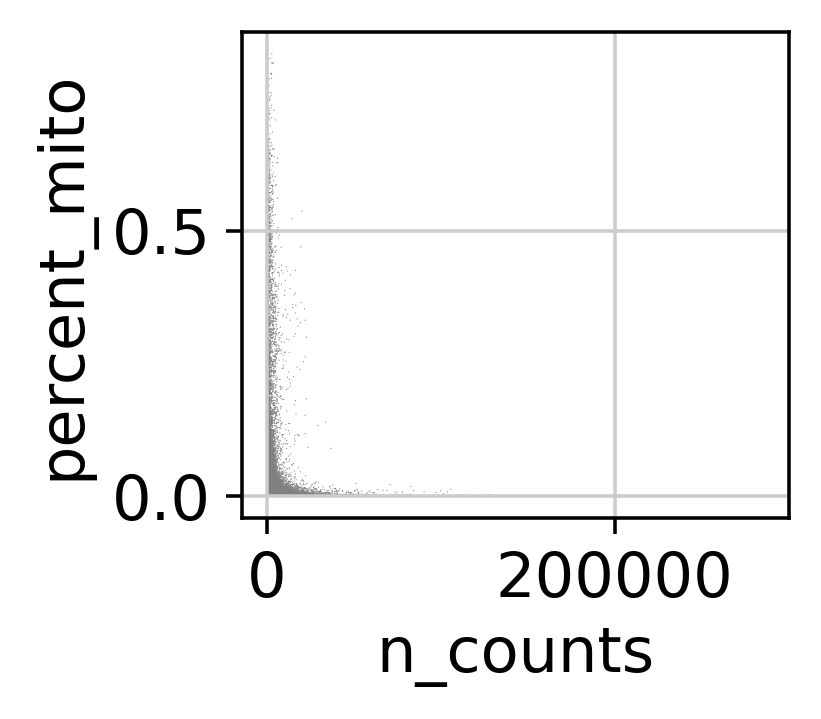

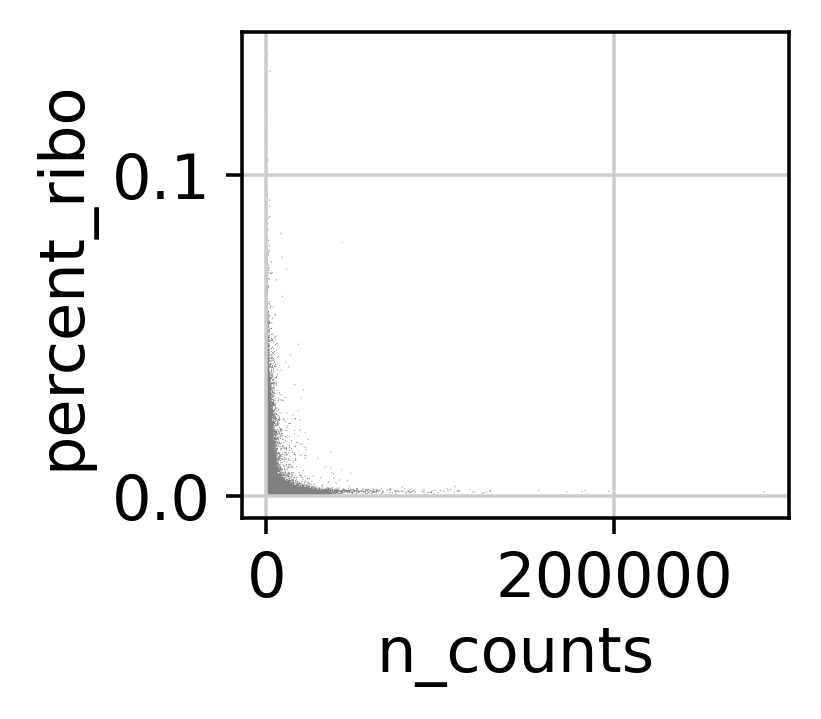

In [13]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo')

## Remove cells exceeding the ribo/mito threshold

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


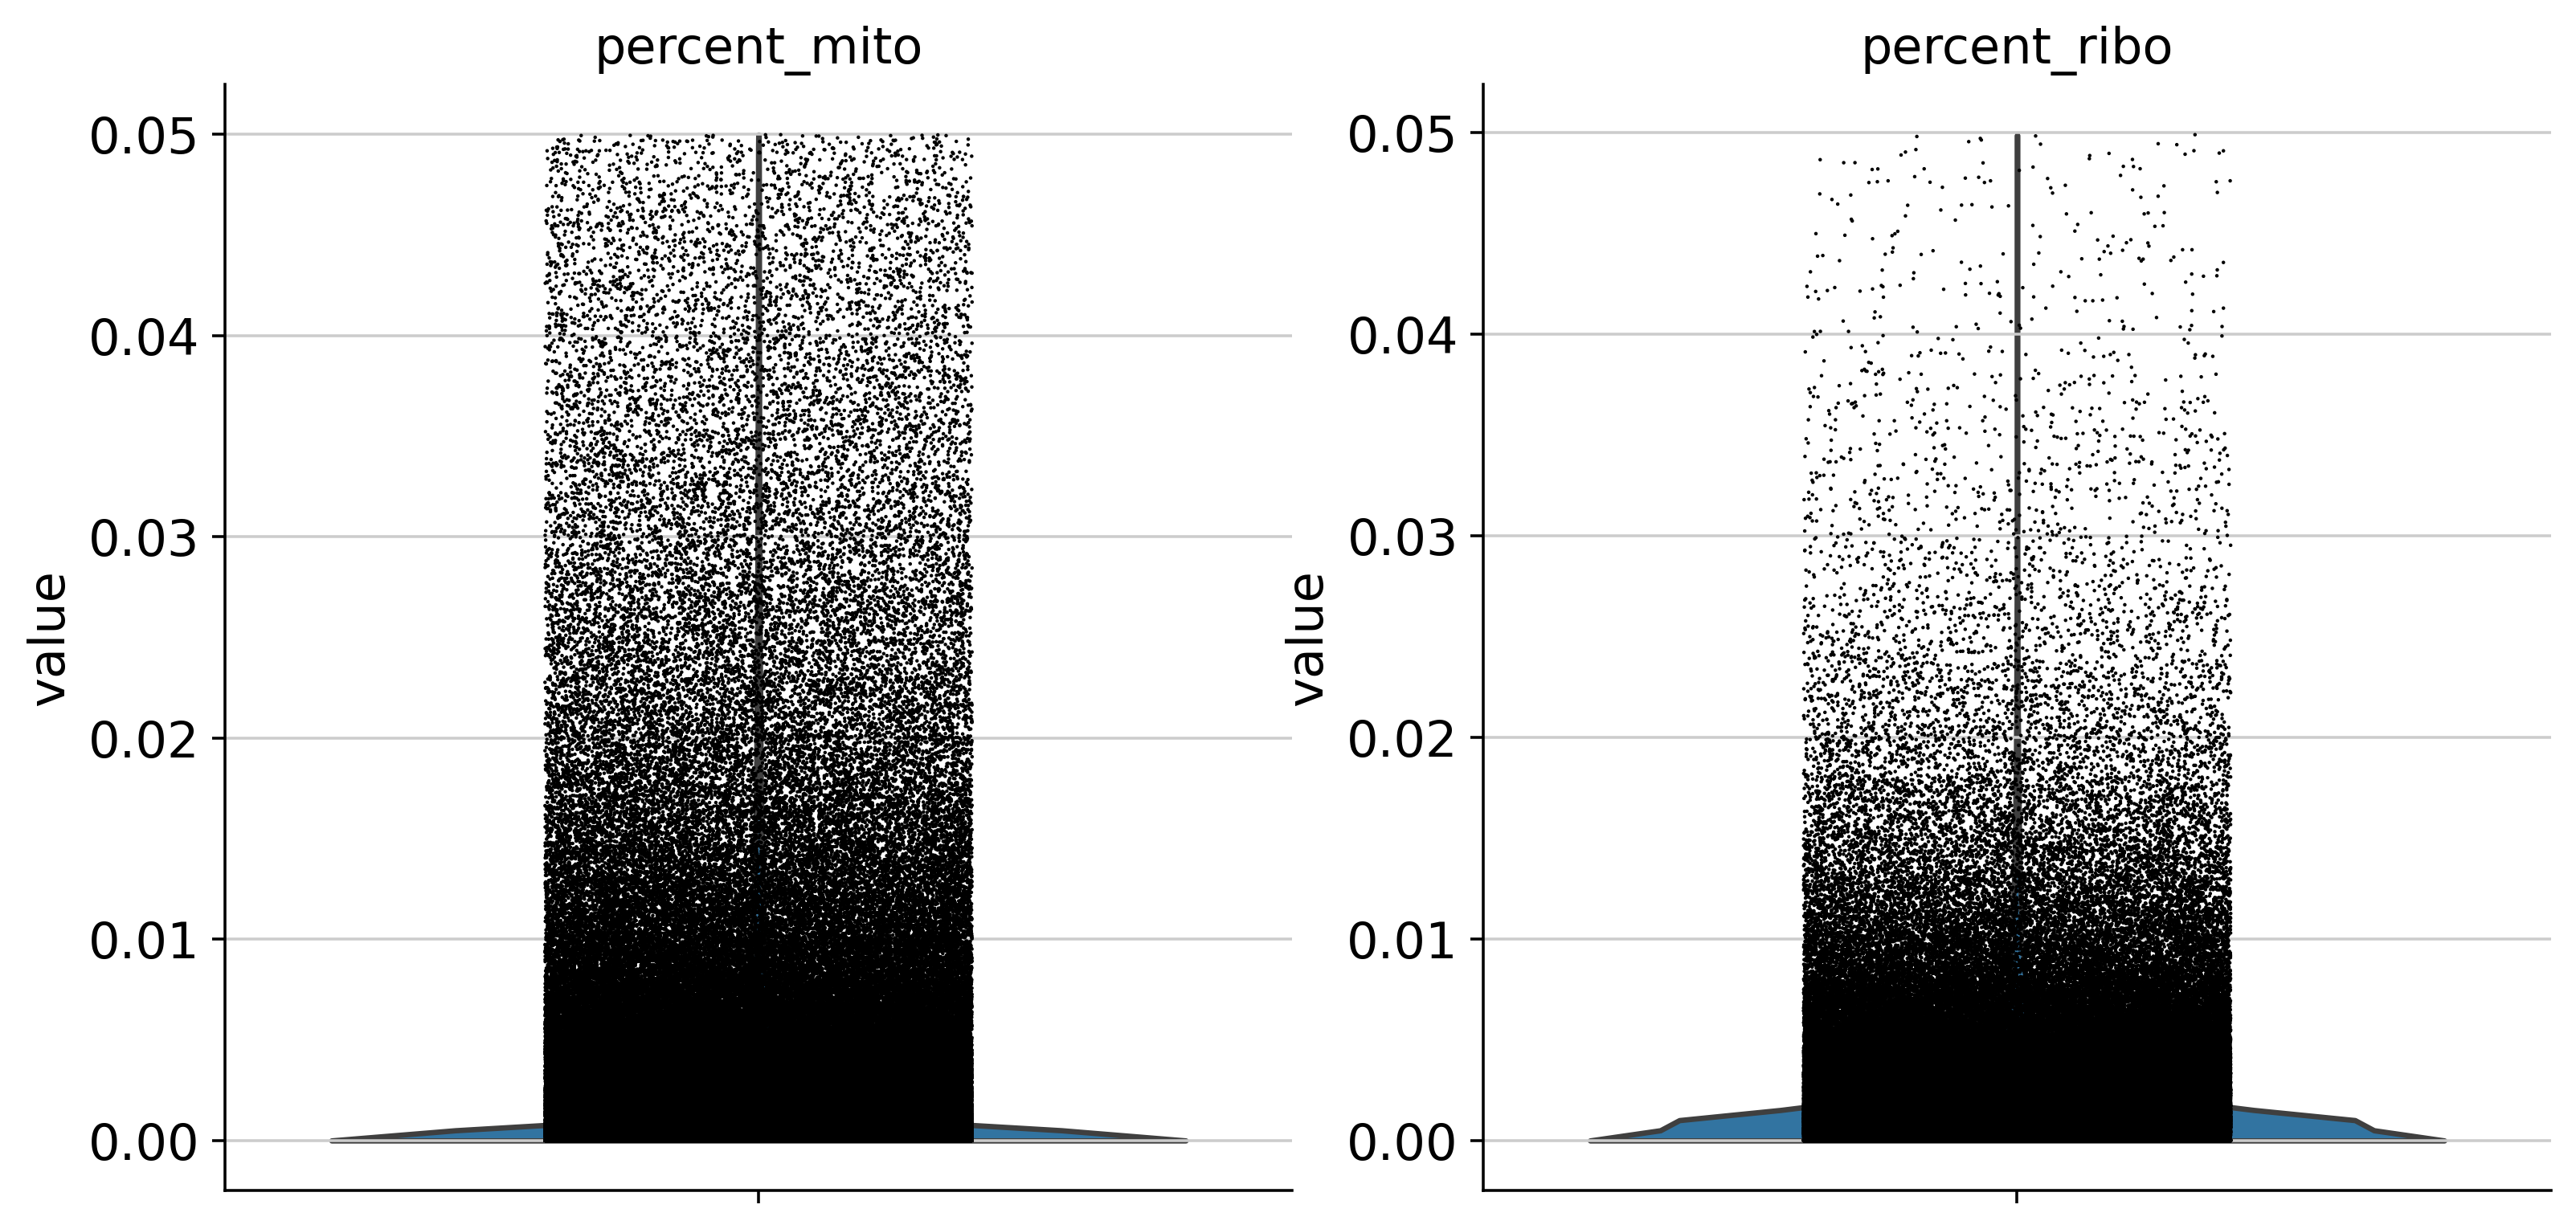

In [14]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata = adata[adata.obs['percent_ribo'] < 0.05, :]
sc.pl.violin(adata, ['percent_mito', 'percent_ribo'],jitter = 0.2, multi_panel = True)

In [15]:
adata.shape

(433771, 29919)

In [16]:
adata_backup = adata.copy()

In [17]:
for i in range(len(metadata.index)):
    ad = adata[adata.obs.sample_id == metadata.index[i],:].copy()
    run_scrublet(ad)
    if i==0:
        meta = ad.obs
    else:
        meta = pd.concat([meta, ad.obs])
    del ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_ca

In [18]:
meta_scrub = meta.loc[:,['scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval']].copy()

In [19]:
if meta.index.equals(adata.obs.index):
    adata.obs = pd.concat([adata.obs, meta_scrub], axis=1)
else:
    raise Exception('Different barcodes in meta and adata')

In [20]:
adata.write('/nfs/team205/heart/anndata_objects/snRNA_adult.h5ad')

... storing 'scrublet_leiden' as categorical
